## 1. BMI & 체지방률 & 체지방량 & 근육량(제지방량)기반으로 체형 분류


🔍 모델: RandomForest - GridSearchCV 시작...
✅ Best params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
🎯 정확도: 0.9861 | 교차검증: 0.9829
💾 RandomForest 모델 번들 저장 완료: RandomForest_bundle.pkl


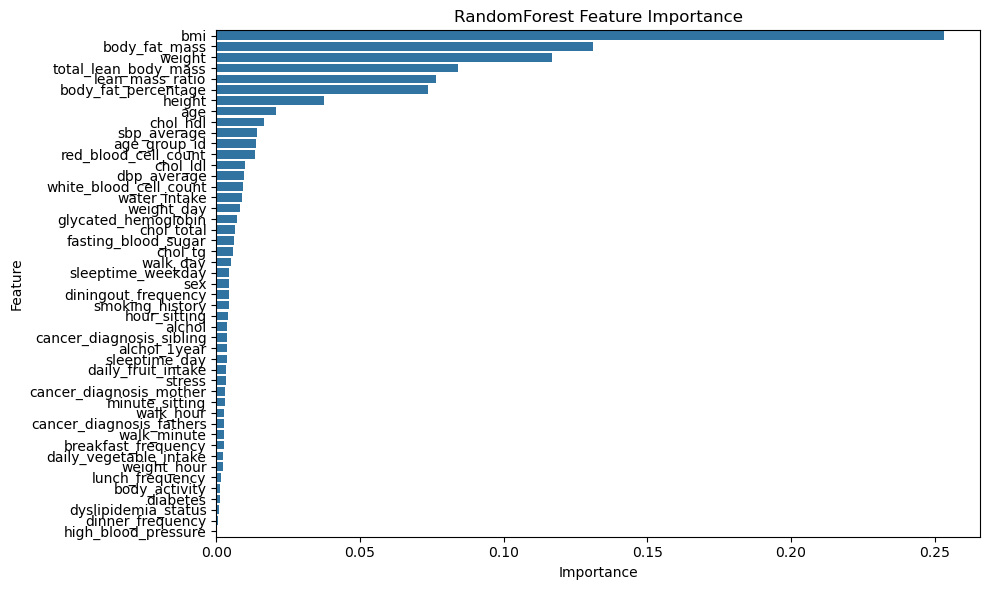


🔍 모델: XGBoost - GridSearchCV 시작...
✅ Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
🎯 정확도: 0.9934 | 교차검증: 0.9914
💾 XGBoost 모델 번들 저장 완료: XGBoost_bundle.pkl


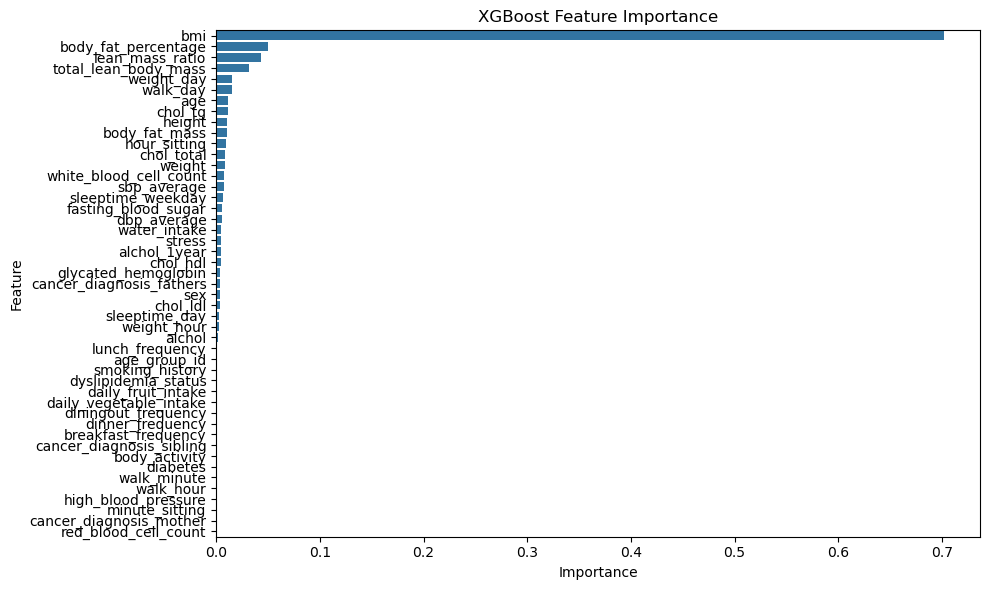


🔍 모델: LightGBM - GridSearchCV 시작...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3811
[LightGBM] [Info] Number of data points in the train set: 5448, number of used features: 47
[LightGBM] [Info] Start training from score -1.600848
[LightGBM] [Info] Start training from score -5.047656
[LightGBM] [Info] Start training from score -3.030850
[LightGBM] [Info] Start training from score -6.118097
[LightGBM] [Info] Start training from score -2.149379
[LightGBM] [Info] Start training from score -1.343888
[LightGBM] [Info] Start training from score -1.010638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

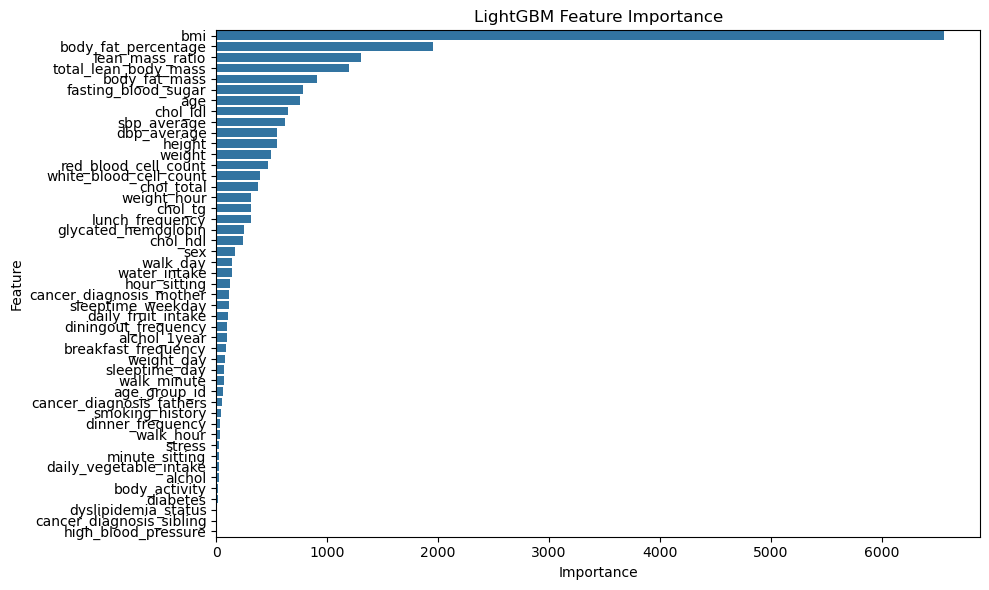


🔍 모델: CatBoost - GridSearchCV 시작...
✅ Best params: {'depth': 6, 'iterations': 100, 'learning_rate': 0.1}
🎯 정확도: 0.9941 | 교차검증: 0.9916
💾 CatBoost 모델 번들 저장 완료: CatBoost_bundle.pkl


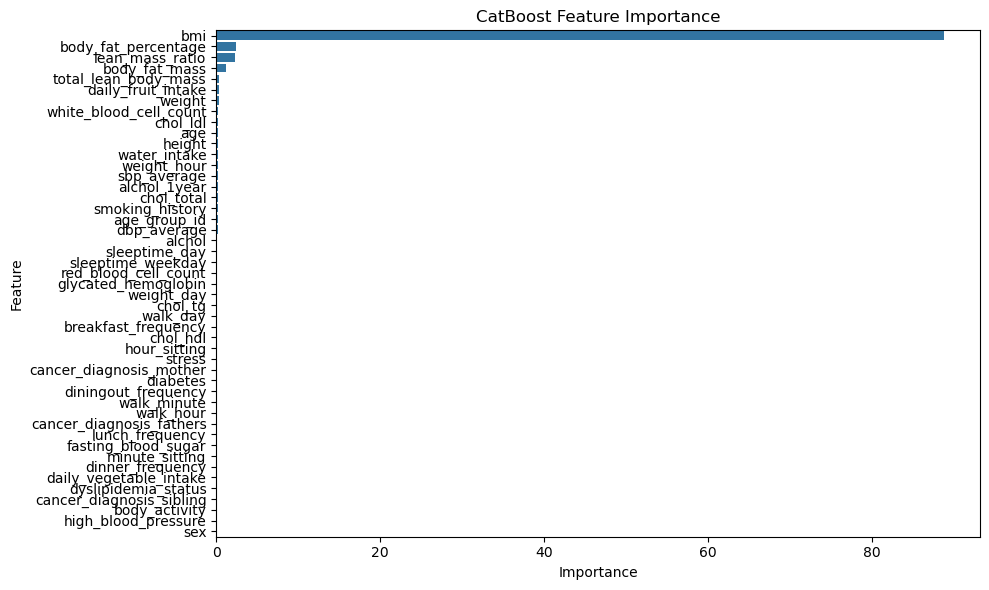

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import warnings
import joblib

warnings.filterwarnings("ignore")

# ✅ 데이터 로드
file_path_dataset = r"C:/project/finfit/static/dataset/final_dataset_v6.csv"
df = pd.read_csv(file_path_dataset)
df.replace([8, 88, 9, 99, 999], np.nan, inplace=True)

# ✅ 체성분 계산 함수 정의
def calculate_bmi(weight, height): return weight / ((height / 100) ** 2)
def calculate_body_fat_percentage(bmi, age, sex): return (1.20 * bmi) + (0.23 * age) - (16.2 if sex == 1 else 5.4)
def calculate_lean_body_mass(weight, body_fat_percentage): return weight * (1 - (body_fat_percentage / 100))
def calculate_fat_mass(weight, body_fat_percentage): return weight * (body_fat_percentage / 100)

# ✅ 체성분 컬럼 계산
df["bmi"] = df.apply(lambda row: calculate_bmi(row["weight"], row["height"]) if pd.isna(row["bmi"]) else row["bmi"], axis=1)
df["body_fat_percentage"] = df.apply(lambda row: calculate_body_fat_percentage(row["bmi"], row["age"], row["sex"]) if pd.isna(row["body_fat_percentage"]) else row["body_fat_percentage"], axis=1)
df["total_lean_body_mass"] = df.apply(lambda row: calculate_lean_body_mass(row["weight"], row["body_fat_percentage"]) if pd.isna(row["total_lean_body_mass"]) else row["total_lean_body_mass"], axis=1)
df["body_fat_mass"] = df.apply(lambda row: calculate_fat_mass(row["weight"], row["body_fat_percentage"]) if pd.isna(row["body_fat_mass"]) else row["body_fat_mass"], axis=1)

# ✅ 체형 분류 함수
def classify_body_type_final(bmi, body_fat_percentage, lean_mass_ratio, sex):
    if sex == 1:
        if bmi < 18.5: return "마른 비만형" if body_fat_percentage >= 25 else "마른형"
        elif 18.5 <= bmi < 23: return "표준형"
        elif 23 <= bmi < 25: return "과체중형"
        elif 25 <= bmi < 30:
            if body_fat_percentage < 20 and lean_mass_ratio > 0.7: return "근육형"
            else: return "비만형"
        else:
            if body_fat_percentage < 25 and lean_mass_ratio > 0.7: return "근육형"
            elif body_fat_percentage >= 30: return "근육형 비만형"
            else: return "비만형"
    else:
        if bmi < 18.5: return "마른 비만형" if body_fat_percentage >= 32 else "마른형"
        elif 18.5 <= bmi < 23: return "표준형"
        elif 23 <= bmi < 25: return "과체중형"
        elif 25 <= bmi < 30:
            if body_fat_percentage < 28 and lean_mass_ratio > 0.65: return "근육형"
            else: return "비만형"
        else:
            if body_fat_percentage < 32 and lean_mass_ratio > 0.65: return "근육형"
            elif body_fat_percentage >= 35: return "근육형 비만형"
            else: return "비만형"

df["lean_mass_ratio"] = df["total_lean_body_mass"] / df["weight"]
df["body_type"] = df.apply(lambda row: classify_body_type_final(
    row["bmi"], row["body_fat_percentage"], row["lean_mass_ratio"], row["sex"]), axis=1)

# ✅ 운동 실천율 계산
def calculate_body_activity(weight_day, weight_hour, walk_day, walk_hour, walk_minute, hour_sitting, minute_sitting):
    walk_total_min = walk_day * ((walk_hour * 60) + walk_minute)
    weight_total_min = weight_day * weight_hour * 60
    sitting_total_min = hour_sitting * 60 + minute_sitting
    return 1 if ((walk_total_min + weight_total_min >= 150) or (weight_total_min >= 75)) and (sitting_total_min < 600) else 0

df["body_activity"] = df.apply(
    lambda row: calculate_body_activity(row["weight_day"], row["weight_hour"], row["walk_day"],
                                        row["walk_hour"], row["walk_minute"], row["hour_sitting"],
                                        row["minute_sitting"]) if pd.isna(row["body_activity"]) else row["body_activity"], axis=1)

# ✅ 결측치 처리
df.dropna(subset=["body_activity"], inplace=True)
df.fillna(df.mean(numeric_only=True), inplace=True)
df.drop(columns=["id", "year", "region", "bmi_category"], errors='ignore', inplace=True)

# ✅ 학습 데이터 분리
X = df.drop(columns=["body_type"])
y = df["body_type"]
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# ✅ 하이퍼파라미터 설정
param_grids = {
    "RandomForest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': ['balanced']
    },
    "XGBoost": {
        'n_estimators': [100],
        'max_depth': [3, 6],
        'learning_rate': [0.05, 0.1]
    },
    "LightGBM": {
        'n_estimators': [100],
        'max_depth': [10, 20],
        'learning_rate': [0.05, 0.1]
    },
    "CatBoost": {
        'iterations': [100],
        'depth': [6, 8],
        'learning_rate': [0.05, 0.1]
    }
}

# ✅ 모델 매핑
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_seed=42)
}

# ✅ 모델 학습, 평가
results = []
reports = {}

for name, model in models.items():
    print(f"\n🔍 모델: {name} - GridSearchCV 시작...")
    grid = GridSearchCV(model, param_grids[name], cv=3, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    print("✅ Best params:", grid.best_params_)

    # 평가
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cv_score = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy').mean()
    print("🎯 정확도:", round(acc, 4), "| 교차검증:", round(cv_score, 4))

    # ✅ 모델 저장 (Flask 호환 구조로)
    bundle = {
        'model': best_model,
        'scaler': scaler,
        'label_encoder': label_encoder,
        'features': X.columns.tolist()
    }
    joblib.dump(bundle, f"{name}_bundle.pkl")
    print(f"💾 {name} 모델 번들 저장 완료: {name}_bundle.pkl")

    # 리포트 저장
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
    reports[name] = pd.DataFrame(report).T

    # Feature Importance 시각화
    if hasattr(best_model, "feature_importances_"):
        importances = best_model.feature_importances_
        importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=importance_df)
        plt.title(f"{name} Feature Importance")
        plt.tight_layout()
        plt.show()

    # 결과 저장
    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "CV Accuracy": round(cv_score, 4),
        "Best Params": grid.best_params_
    })



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3811
[LightGBM] [Info] Number of data points in the train set: 5448, number of used features: 47
[LightGBM] [Info] Start training from score -1.600848
[LightGBM] [Info] Start training from score -5.047656
[LightGBM] [Info] Start training from score -3.030850
[LightGBM] [Info] Start training from score -6.118097
[LightGBM] [Info] Start training from score -2.149379
[LightGBM] [Info] Start training from score -1.343888
[LightGBM] [Info] Start training from score -1.010638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

('C:/project/finfit/exercise_models.pkl',
 'C:/project/finfit/lgbm_feature_importance.png')

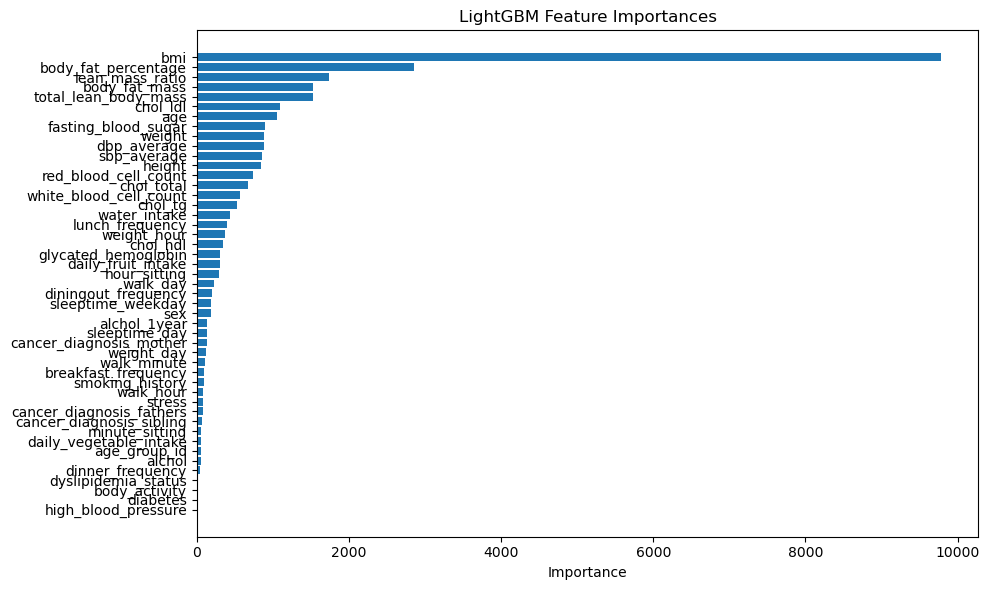

In [10]:
# LightGBM 다중분류 + 이진분류 모델 학습 (확장된 param_grid & feature_importances 포함)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
import joblib
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리
df = pd.read_csv("C:/project/finfit/static/dataset/final_dataset_v6.csv")
df.replace([8, 88, 9, 99, 999], np.nan, inplace=True)

def calculate_bmi(weight, height): return weight / ((height / 100) ** 2)
def calculate_body_fat_percentage(bmi, age, sex): return (1.20 * bmi) + (0.23 * age) - (16.2 if sex == 1 else 5.4)
def calculate_lean_body_mass(weight, body_fat_percentage): return weight * (1 - (body_fat_percentage / 100))
def calculate_fat_mass(weight, body_fat_percentage): return weight * (body_fat_percentage / 100)

df["bmi"] = df.apply(lambda row: calculate_bmi(row["weight"], row["height"]) if pd.isna(row["bmi"]) else row["bmi"], axis=1)
df["body_fat_percentage"] = df.apply(lambda row: calculate_body_fat_percentage(row["bmi"], row["age"], row["sex"]) if pd.isna(row["body_fat_percentage"]) else row["body_fat_percentage"], axis=1)
df["total_lean_body_mass"] = df.apply(lambda row: calculate_lean_body_mass(row["weight"], row["body_fat_percentage"]) if pd.isna(row["total_lean_body_mass"]) else row["total_lean_body_mass"], axis=1)
df["body_fat_mass"] = df.apply(lambda row: calculate_fat_mass(row["weight"], row["body_fat_percentage"]) if pd.isna(row["body_fat_mass"]) else row["body_fat_mass"], axis=1)

def classify_body_type_final(bmi, body_fat_percentage, lean_mass_ratio, sex):
    if sex == 1:
        if bmi < 18.5: return "마른 비만형" if body_fat_percentage >= 25 else "마른형"
        elif 18.5 <= bmi < 23: return "표준형"
        elif 23 <= bmi < 25: return "과체중형"
        elif 25 <= bmi < 30:
            if body_fat_percentage < 20 and lean_mass_ratio > 0.7: return "근육형"
            else: return "비만형"
        else:
            if body_fat_percentage < 25 and lean_mass_ratio > 0.7: return "근육형"
            elif body_fat_percentage >= 30: return "근육형 비만형"
            else: return "비만형"
    else:
        if bmi < 18.5: return "마른 비만형" if body_fat_percentage >= 32 else "마른형"
        elif 18.5 <= bmi < 23: return "표준형"
        elif 23 <= bmi < 25: return "과체중형"
        elif 25 <= bmi < 30:
            if body_fat_percentage < 28 and lean_mass_ratio > 0.65: return "근육형"
            else: return "비만형"
        else:
            if body_fat_percentage < 32 and lean_mass_ratio > 0.65: return "근육형"
            elif body_fat_percentage >= 35: return "근육형 비만형"
            else: return "비만형"

df["lean_mass_ratio"] = df["total_lean_body_mass"] / df["weight"]
df["body_type"] = df.apply(lambda row: classify_body_type_final(row["bmi"], row["body_fat_percentage"], row["lean_mass_ratio"], row["sex"]), axis=1)

def calculate_body_activity(weight_day, weight_hour, walk_day, walk_hour, walk_minute, hour_sitting, minute_sitting):
    walk_total_min = walk_day * ((walk_hour * 60) + walk_minute)
    weight_total_min = weight_day * weight_hour * 60
    sitting_total_min = hour_sitting * 60 + minute_sitting
    return 1 if ((walk_total_min + weight_total_min >= 150) or (weight_total_min >= 75)) and (sitting_total_min < 600) else 0

df["body_activity"] = df.apply(
    lambda row: calculate_body_activity(row["weight_day"], row["weight_hour"], row["walk_day"],
                                        row["walk_hour"], row["walk_minute"], row["hour_sitting"],
                                        row["minute_sitting"]) if pd.isna(row["body_activity"]) else row["body_activity"], axis=1)

df.dropna(subset=["body_activity"], inplace=True)
df.fillna(df.mean(numeric_only=True), inplace=True)
df.drop(columns=["id", "year", "region", "bmi_category"], errors='ignore', inplace=True)

# 학습 데이터 준비
X = df.drop(columns=["body_type"])
y = df["body_type"]
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# LightGBM 다중 분류 모델 학습 (확장된 param_grid)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'learning_rate': [0.05, 0.1]
}
grid = GridSearchCV(LGBMClassifier(random_state=42), param_grid, cv=3, scoring="accuracy", n_jobs=-1)
grid.fit(X_train, y_train)
lgbm_model = grid.best_estimator_

# Feature Importance 시각화
importances = lgbm_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Importance")
plt.title("LightGBM Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("C:/project/finfit/lgbm_feature_importance.png")

# 이진 분류기 학습
df["binary_lean_obese"] = (df["body_type"] == "마른 비만형").astype(int)
df["binary_muscular"] = (df["body_type"] == "근육형").astype(int)

binary_lean_obese_model = LGBMClassifier(random_state=42)
binary_lean_obese_model.fit(X_scaled, df["binary_lean_obese"])

binary_muscular_model = LGBMClassifier(random_state=42)
binary_muscular_model.fit(X_scaled, df["binary_muscular"])

# 모델 통합 저장
bundle = {
    "model": lgbm_model,
    "scaler": scaler,
    "label_encoder": label_encoder,
    "features": X.columns.tolist(),
    "binary_lean_obese": binary_lean_obese_model,
    "binary_muscular": binary_muscular_model
}
output_path = "C:/project/finfit/exercise_models.pkl"
joblib.dump(bundle, output_path)

output_path, "C:/project/finfit/lgbm_feature_importance.png"
